    Data: tpu-getting-started,tf-flower-photo-tfrec

In [40]:
import math,re,os,random
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from sklearn.metrics import f1_score, precision_score, recall_score,confusion_matrix

print("TF version: " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE


TF version: 2.2.0


In [41]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Running on TPU", tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)


Running on TPU grpc://10.0.0.2:8470
REPLICAS:  8


In [42]:
IMAGE_SIZE = [224, 224]
EPOCHS = 35
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
SEED = 752
SKIP_VALIDATION = False
TTA_NUM = 5

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [43]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')
GCS_DS_PATH_EXT = KaggleDatasets().get_gcs_path('tf-flower-photo-tfrec')

GCS_PATH_SELECT = {
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

GCS_PATH_SELECT_EXT = {
    192: '/tfrecords-jpeg-192x192',
    224: '/tfrecords-jpeg-224x224',
    331: '/tfrecords-jpeg-331x331',
    512: '/tfrecords-jpeg-512x512'
}
GCS_PATH_EXT = GCS_PATH_SELECT_EXT[IMAGE_SIZE[0]]

IMAGENET_FILES = tf.io.gfile.glob(GCS_DS_PATH_EXT + '/imagenet' + GCS_PATH_EXT + '/*.tfrec')
INATURELIST_FILES = tf.io.gfile.glob(GCS_DS_PATH_EXT + '/inaturalist' + GCS_PATH_EXT + '/*.tfrec')
OPENIMAGE_FILES = tf.io.gfile.glob(GCS_DS_PATH_EXT + '/openimage' + GCS_PATH_EXT + '/*.tfrec')
OXFORD_FILES = tf.io.gfile.glob(GCS_DS_PATH_EXT + '/oxford_102' + GCS_PATH_EXT + '/*.tfrec')
TENSORFLOW_FILES = tf.io.gfile.glob(GCS_DS_PATH_EXT + '/tf_flowers' + GCS_PATH_EXT + '/*.tfrec')

ADDITIONAL_TRAINING_FILENAMES = IMAGENET_FILES + INATURELIST_FILES + OPENIMAGE_FILES + OXFORD_FILES + TENSORFLOW_FILES

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']    
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec')

TRAINING_FILENAMES = TRAINING_FILENAMES + ADDITIONAL_TRAINING_FILENAMES

In [44]:

np.set_printoptions(threshold = 15, linewidth = 80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object:
        numpy_labels = [None for _ in enumerate(numpy_images)]
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO',
                                u"\u2192" if not correct else '',
                               CLASSES[correct_label] if not correct else''),correct

def display_one_flower(image,title, subplot, red = False, titlesize = 16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize = int(titlesize) if not red 
                 else int(titlesize /1.2), color = 'red' if red else 'black',fontdict={'verticalalignment': 'center'}, pad = int(titlesize / 1.5))
    return (subplot[0], subplot[1], subplot[2] + 1)

def display_batch_of_images(databatch, predictions = None):
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
    
    rows = int(math.sqrt(len(images)))
    cols = len(images) // rows
    
    FIGSIZE  = 13.0
    SPACING = 0.1
    subplot = (rows, cols, 1)
    if rows < cols:
        plt.figure(figsize = (FIGSIZE, FIGSIZE / cols * rows))
    else:
        plt.figure(figsize = (FIGSIZE / rows * cols, FIGSIZE))
    
    for i, (image, label) in enumerate(zip(images[:rows * cols], labels[:rows * cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE * SPACING / max(rows, cols) * 40 + 3
        subplot = display_one_flower(image, title, subplot, not correct, titlesize = dynamic_titlesize)
        
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace = 0, hspace = 0)
    else:
        plt.subplots_adjust(wspace = SPACING, hspace = SPACING)
    plt.show()

        
def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize = (15, 15))
    ax = plt.gca()
    ax.matshow(cmat, cmap = 'Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict = {'fontsize' : 7})
    plt.setp(ax.get_xticklabels(), rotation = 45, ha = 'left', rotation_mode = "anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict = {'fontsize' : 7})
    plt.setp(ax.get_yticklabels(), rotation = 45, ha = 'right', rotation_mode = "anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {: .3f}'.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f}'.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f}'.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict = {'fontsize' : 18, 'horizontalalignment':'right',
                                                'verticalalignment':'top', 'color':'#804040'})
    plt.show()

def display_training_curves(training, validation, title, subplot):
    if subplot % 10 == 1:
        plt.subplots(figsize = (10, 10), facecolor = '#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model ' + title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28, 1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])


In [45]:
def random_blockout(img, sl = 0.1, sh = 0.2, rl = 0.4):
    p = random.random()
    if p >= 0.25:
        w, h, c = IMAGE_SIZE[0], IMAGE_SIZE[1], 3
        origin_area = tf.cast(h * w, tf.float32)
        
        e_size_l = tf.cast(tf.round(tf.sqrt(origin_area * sl * rl)), tf.int32)
        e_size_h = tf.cast(tf.round(tf.sqrt(origin_area * sh / rl)), tf.int32)
        
        e_height_h = tf.minimum(e_size_h, h)
        e_width_h = tf.minimum(e_size_h, w)
        
        erase_height = tf.random.uniform(shape = [], minval = e_size_l, maxval = e_height_h, dtype = tf.int32)
        erase_width = tf.random.uniform(shape = [], minval = e_size_l, maxval = e_width_h, dtype = tf.int32)
        
        erase_area = tf.zeros(shape = [erase_height, erase_width, c])
        erase_area = tf.cast(erase_area, tf.uint8)
        
        pad_h = h - erase_height
        pad_top = tf.random.uniform(shape = [], minval = 0, maxval = pad_h, dtype = tf.int32)
        pad_bottom = pad_h - pad_top
        
        pad_w = w - erase_width
        pad_left = tf.random.uniform(shape = [], minval = 0, maxval = pad_w, dtype = tf.int32)
        pad_right = pad_w - pad_left
        
        erase_mask = tf.pad([erase_area], [[0,0],[pad_top,pad_bottom],[pad_left, pad_right],[0,0]],
                            constant_values = 1)
        erase_mask = tf.squeeze(erase_mask, axis= 0)
        erased_img = tf.multiply(tf.cast(img, tf.float32), tf.cast(erase_mask, tf.float32))
        return tf.cast(erased_img, img.dtype)
    else:
        return tf.cast(img, img.dtype)


In [46]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels = 3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image



def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {"image": tf.io.FixedLenFeature([], tf.string),
                           "class":tf.io.FixedLenFeature([], tf.int64)}
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example["image"])
    label = tf.cast(example["class"], tf.int32)
    return image, label



def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'id': tf.io.FixedLenFeature([], tf.string)}
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum


def load_dataset(filenames, labeled = True, ordered = False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, 
                          num_parallel_calls = AUTO)
    return dataset

def data_augment(image, label):
    image = tf.image.random_flip_left_right(image, seed = SEED)
    image = random_blockout(image)
    return image, label

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_validation_dataset(ordered = False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled = True, ordered = ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered = False):
    dataset = load_dataset(TEST_FILENAMES, labeled = False, ordered = ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES,NUM_VALIDATION_IMAGES,NUM_TEST_IMAGES))


Dataset: 68094 training images, 3712 validation images, 7382 unlabeled test images


In [47]:
if SKIP_VALIDATION:
    TRAINING_FILENAMES = TRAINING_FILENAMES + VALIDATION_FILENAMES

In [48]:
print("Training data shapes:")
for image, label in get_training_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())
print("Validation data shapes:")
for image, label in get_validation_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Validation data label examples:", label.numpy())
print("Test data shapes:")
for image, idnum in get_test_dataset().take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs: ", idnum.numpy().astype('U'))

Training data shapes:
(128, 224, 224, 3) (128,)
(128, 224, 224, 3) (128,)
(128, 224, 224, 3) (128,)
Training data label examples: [77 16 49 ... 95 53 12]
Validation data shapes:
(128, 224, 224, 3) (128,)
(128, 224, 224, 3) (128,)
(128, 224, 224, 3) (128,)
Validation data label examples: [ 29   4 103 ...  68  95  64]
Test data shapes:
(128, 224, 224, 3) (128,)
(128, 224, 224, 3) (128,)
(128, 224, 224, 3) (128,)
Test data IDs:  ['b87e16bc0' 'd8437a7f7' '981396649' ... '15cb0c24a' '1c3a7bc99' 'b20b97998']


In [49]:
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)

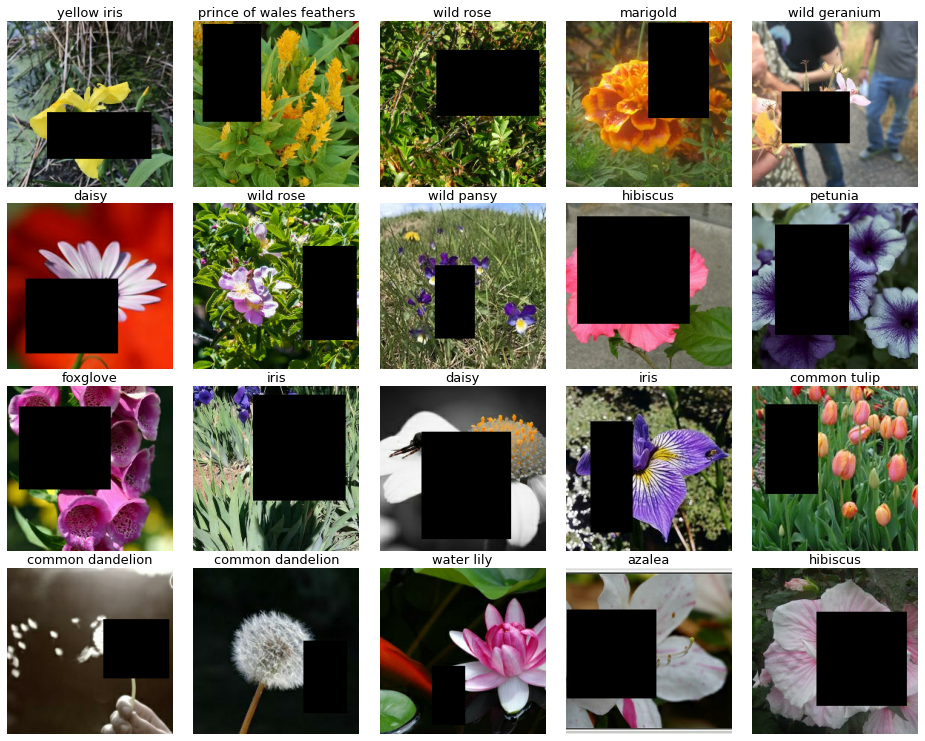

In [50]:
display_batch_of_images(next(train_batch))

In [51]:
test_dataset = get_test_dataset()
test_dataset = test_dataset.unbatch().batch(20)
test_batch = iter(test_dataset)


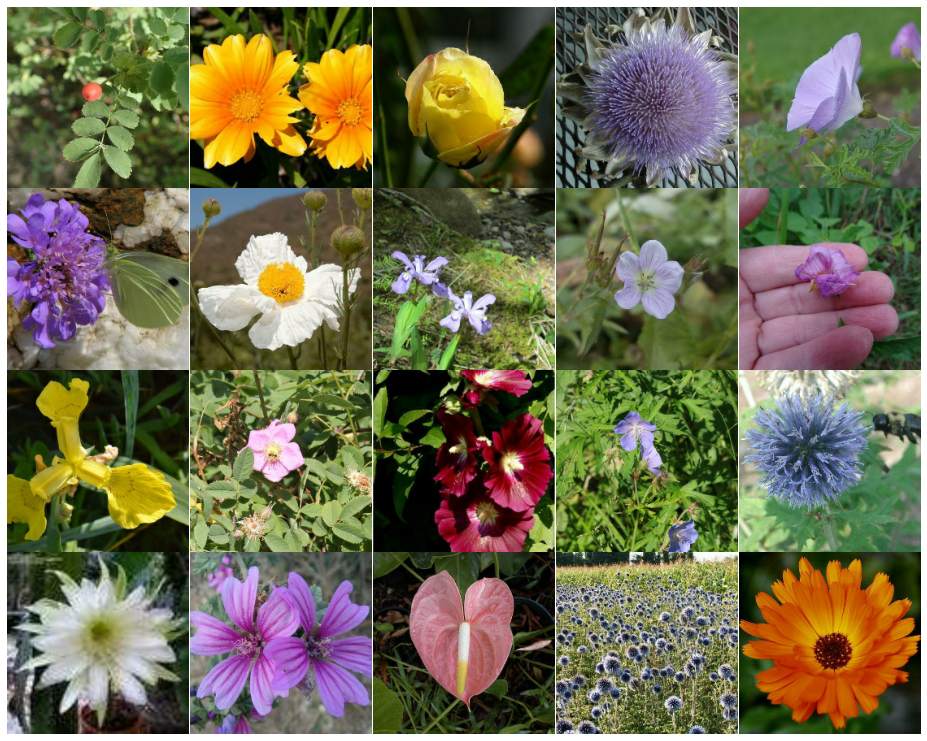

In [52]:
display_batch_of_images(next(test_batch))

Learning rate schedule:  1e-05 to  0.0004 to 1.06e-05


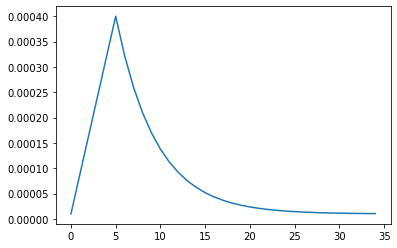

In [53]:
LR_START = 0.00001
# LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = 0.8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY ** (epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

rng = [i for i in range(25 if EPOCHS < 25 else EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {: .3g} to {: .3g} to {:.3g}".format(y[0], max(y), y[-1]))
    

# EfficientNet B7

In [54]:
!pip install -q efficientnet
import efficientnet.tfkeras as efn

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [61]:
with strategy.scope():
    enet = efn.EfficientNetB7(input_shape = [*IMAGE_SIZE, 3],
                              weights = 'noisy-student', include_top = False)
    enet.trainable = True
    model1 = tf.keras.Sequential([
        enet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation = 'softmax')
    ])
    
model1.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['sparse_categorical_accuracy']
    
)
model1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Model)      (None, 7, 7, 2560)        64097680  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 2560)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 104)               266344    
Total params: 64,364,024
Trainable params: 64,053,304
Non-trainable params: 310,720
_________________________________________________________________


In [ ]:
if not SKIP_VALIDATION:
    history1 = model1.fit(get_training_dataset(),
                        steps_per_epoch = STEPS_PER_EPOCH,
                        epochs = EPOCHS,
                        validation_data = get_validation_dataset(),
                        callbacks = [lr_callback])
else:
    history1 = model1.fit(get_training_dataset(),
                        steps_per_epoch = STEP_PER_EPOCH,
                        epochs = EPOCHS,
                        callbacks = [lr_callback])


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/35
531/531 [==============================] - 178s 335ms/step - sparse_categorical_accuracy: 0.0963 - loss: 4.3635 - val_sparse_categorical_accuracy: 0.0466 - val_loss: 4.3490 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/35
100/531 [====>.........................] - ETA: 1:58 - sparse_categorical_accuracy: 0.2108 - loss: 3.4225

# DenseNet201

In [ ]:
with strategy.scope():
    densenet = tf.keras.applications.DenseNet201(input_shape = [*IMAGE_SIZE, 3],weights = 'imagenet', include_top = False)
    densenet.trainable = True
    
    model2 = tf.keras.Sequential([
        densenet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation = 'softmax')
    ])

model2.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['sparse_categorical_accuracy'])
model2.summary()

In [ ]:
if not SKIP_VALIDATION:
    history2 = model2.fit(get_training_dataset(),
                         steps_per_epoch = STEPS_PER_EPOCH,
                         epochs = EPOCHS,
                         validation_data = get_validation_dataset(),
                         callbacks = [lr_callback])
else:
    history2 = model2.fit(get_training_dataset(),
                         steps_per_epoch = STEPS_PER_EPOCH,
                         epochs = EPOCHS,
                         callback = [lr_callback])

In [ ]:
if not SKIP_VALIDATION:
    cmdataset = get_validation_dataset(ordered = True)
    images_ds = cmdataset.map(lambda image, label: image)
    labels_ds = cmdataset.map(lambda image, label: label).unbatch()
    cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()
    m1 = model1.preidct(images_ds)
    m2 = model2.preidct(images_ds)
    scores = []
    for alpha in np.linspace(0,1,100):
        cm_probabilities = alpha * m1 + (1 - alpha) * m2
        cm_predictions = np.argmax(cm_probabilities, axis = -1)
        scores.append(f1_score(cm_correct_labels, cm_predictions, labels = range(len(CLASSES)), average = 'macro'))
    best_alpha = np.argmax(scores) / 100
else:
    best_alpha = 0.51
                      

In [ ]:
if not SKIP_VALIDATION:
    cm_probabilities = best_alpha * m1 + (1 - best_alpha) * m2
    cm_predctions = np.argmax(cm_probabilities, axis = -1)
    cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels = range(len(CLASSES)))
    score = f1_score(cm_correct_labels, cm_predictions, labels = range(len(CLASSES)), average = 'macro')
    precision = precisino_score(cm_correct_labels, cm_predictions, labels = range(len(CALSSES)), average = 'macro')
    recall = recall_score(cm_correct_labels, cm_predictons, labels = range(len(CLSSSES)), average = 'macro')
    display_confusion_matrix(cmat, score, precision, recall)
    print("f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}".format(score, precision, recall))

In [ ]:
def predict_tta(model, n_iter):
    probs = []
    for i in range(n_iter):
        test_ds = get_test_dataset(ordered = True)
        test_iamges_ds = test_ds.map(lambda image, idnum: image)
        probs.append(model.predict(test_images_ds, verbose = 0))
    return probs

In [ ]:
test_ds = get_test_dataset(ordered = True)
print('Calculating predictions....')
test_images_ds = test_ds.map(lambda image, idnum : image)
probs1 = np.mead(predict_tta(model1, TTA_NUM), axis = 0)
probs2 = np.mean(predict_tta(model2, TTA_NUM), axis = 0)
probabilities = best_alpha * probs1 + (1 - best_alpha) * probs2
predictions = np.argmax(probabilitiesm, axis = -1)

print("Generating submission file...")
test_ids_ds = test_ds.map(lambda image, idnum:idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')
np.savetext('submission.csv', np.rec.fromarrys([test_ids, predictions]), fmt = ['%s', '%d'], delimiter = ',', header = 'id, label', comments = '')
                 